# Pytorch Baseline

In [1]:
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from tqdm import tqdm_notebook as tqdm
import warnings
import joblib

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data Path 경로

In [2]:
dataset_path = '../data/KAERI_dataset/'

# Stratified Group K-fold

원하는 방법으로 데이터를 나누고, 학습에 활용합니다.
여기서는 Stratified Group K-fold를 수행했습니다. (K = 5)

- M, V를 그룹(Group)으로 하고 stratified k-fold함
- train data를 살펴보면 시뮬레이션으로 위치를 생성했기 때문에 위치는 크게 의미없다고 판단함

(가독성을 위해 Fold를 나누는 부분은 하단에 추가)

미리 저장된 folds를 불러옵니다.

In [3]:
df_folds = pd.read_csv('../folds_0616.csv')

In [4]:
df_folds.head()

,id,X,Y,M,V,stratified_group,labels,fold
0,1088,-300.0,-400.0,50.0,0.4,26,"-300.0,-400.0,50.0,0.4",1
1,772,-200.0,400.0,75.0,0.6,32,"-200.0,400.0,75.0,0.6",4
2,2161,300.0,400.0,75.0,0.6,32,"300.0,400.0,75.0,0.6",0
3,1192,-300.0,-300.0,175.0,0.8,18,"-300.0,-300.0,175.0,0.8",3
4,1916,-300.0,-300.0,25.0,0.8,23,"-300.0,-300.0,25.0,0.8",1


# Dataset

Train, Test 데이터를 pickle로 저장했다가 load합니다.
- 가독성을 위해 pickle로 저장하는 부분은 하단에 추가

미리 작성된 model(Resnet 등)을 활용하기 위해 1 channel을 3 channel로 변경합니다.
- 모델 입력을 1 channel로 변경할 수도 있지만 편의상 데이터를 가공할 때 3 channel로 하였습니다.

In [5]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.labels = labels.labels
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test:
            #print("test") # if you want to do something in test mode, need to add
            image, labels = self.load_image(index)
        else:
            image, labels = self.load_image(index)

        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        return image, labels

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image(self, index):
        image_id = self.image_ids[index]
        image = joblib.load(f'../data/train_images/train_{image_id}.pkl')
        #image = image[:, :, np.newaxis]
        image = np.repeat(image, 3, 2)

        
        labels = self.labels[index]
        labels = [np.float32(i) for i in labels.split(",")]

        return image, np.array(labels)

# Albumentations

* ToTensorV2가 적합하지 않을 수도 있습니다. (ToTensorV2는 baseline 예시로 작성함)
* ToTensor와 다른 Normalize 방법을 쓰셔도 됩니다.

In [6]:
def train_transforms():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ], p=1.0)

def valid_transforms():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ], p=1.0)

In [7]:
# fold 바꿔가면서 실험 후 CV 생성. 빠른 실험을 위해 0으로 고정함
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    labels=df_folds,
    transforms=train_transforms(),
    test=False,
)

df_val = df_folds[(df_folds['fold'] == fold_number)]

validation_dataset = DatasetRetriever(
    image_ids=df_val.index.values,
    labels=df_folds,
    transforms=valid_transforms(),
    test=True,
)

## 데이터 확인

In [8]:
image, targets = train_dataset[0]

x = targets[0]
y = targets[1]
m = targets[2]
v = targets[3]

print(x, y, m, v)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
ax.set_axis_off()
ax.imshow(numpy_image, cmap='gray');

-300.0 -400.0 50.0 0.4


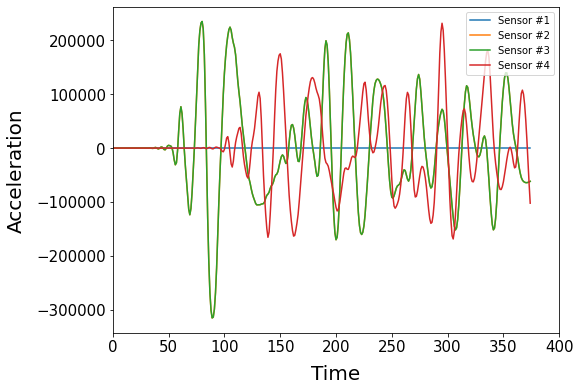

In [9]:
plt.figure(figsize=(8,6))

plt.plot(numpy_image[:,0,0], label="Sensor #1")
plt.plot(numpy_image[:,1,0], label="Sensor #2")
plt.plot(numpy_image[:,2,0], label="Sensor #3")
plt.plot(numpy_image[:,3,0], label="Sensor #4")

plt.xlabel("Time", labelpad=10, size=20)
plt.ylabel("Acceleration", labelpad=10, size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(0, 400)
plt.legend(loc=1)

plt.show()

# Custom loss & Meter

대회에서 제공하는 metric를 이용한 loss입니다.

In [10]:
train_target = 'xy'

In [11]:
def E1_loss(y_true, y_pred):
    _t, _p = y_true[:,:2], y_pred[:,:2]
    return torch.mean(torch.sum(torch.square(_t - _p), 1) / 2e+4)
def E2_loss(y_true, y_pred):
    _t, _p = y_true[:,2:], y_pred[:,2:]
    return torch.mean(torch.sum(torch.square( (_t - _p) / (_t + 1e-6)), 1))

def kaeri_score(y_true, y_pred):
    if train_target == 'xy':
        return E1_loss(y_true, y_pred)
    #elif train_target == 'm':
    #    return E2_loss_m(y_true, y_pred)
    #elif train_target == 'v':
    #    return E2_loss_v(y_true, y_pred)
    elif train_target == 'mv':
        return E2_loss(y_true, y_pred)
    else:
        return 0.5 * E1_loss(y_true, y_pred) + 0.5 * E2_loss(y_true, y_pred)

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class KaeriMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.y_true = np.array([0,0,0,0])
        self.y_pred = np.array([0.5,0.5,0.5,0.5])
        self.score = 0
        
    def update(self, y_true, y_pred):

        self.y_true = y_true.detach().cpu()
        self.y_pred = y_pred.detach().cpu()
        
        self.score = kaeri_score(self.y_true, self.y_pred)
    
    @property
    def avg(self):
        return self.score        

# Fitter

모델을 학습하고, loss 및 score를 계산하는 부분입니다.

In [13]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = './'
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)
            #summary_loss  = self.train_one_epoch(train_loader)
            
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)
            #summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = KaeriMeter()

        t = time.time()
        for step, (images, targets) in enumerate(tqdm(val_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:

                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)

                loss = kaeri_score(targets, outputs)
                
                final_scores.update(targets, outputs)

                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = KaeriMeter()

        t = time.time()
                
        for step, (images, targets) in enumerate(tqdm(train_loader)):

            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device, dtype=torch.float32)
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            
            loss = kaeri_score(targets, outputs)
 
            loss.backward()
            
            final_scores.update(targets, outputs)

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [14]:
class TrainGlobalConfig:
    num_workers = 4 #적절히 수정하세요.
    batch_size = 32 #적절히 수정하세요.
    n_epochs = 10 #적절히 수정하세요.
    lr = 0.001 #적절히 수정하세요.

    folder = 'kaeri_base'

    verbose = True
    verbose_step = 1

    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=2, # 1
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [15]:
def run_training():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

# Model

다른 분들이 많이 쓰는 모델 구조와 pretrained weights를 사용할 수 있습니다. 
- 해당 예시에서는 pretrained=False로 하겠습니다.
- 마지막 layer를 대회 output에 맞게 변경합니다.

In [16]:
import timm

def get_net():
    net = timm.create_model('seresnet18', pretrained=True)
    net.last_linear = nn.Linear(in_features=net.last_linear.in_features, out_features=4, bias=True)
    
    return net

net = get_net().cuda()

# 학습

- fold 바꿔가면서 실험하면 됩니다.
- 여기서는 epoch을 10만 했습니다.

In [17]:
run_training()

Fitter prepared. Device is cuda

2020-06-30T13:36:05.127909
LR: 0.001


Train Step 69/70, summary_loss: 6.69226, final_score: 6.57304, time: 3.05927
[RESULT]: Train. Epoch: 0, summary_loss: 6.69702, final_score: 7.02516, time: 3.15094


Val Step 17/18, summary_loss: 6.65934, final_score: 5.92065, time: 0.32963
[RESULT]: Val. Epoch: 0, summary_loss: 6.69762, final_score: 7.99909, time: 0.43215

2020-06-30T13:36:09.331937
LR: 0.001


Train Step 69/70, summary_loss: 6.68424, final_score: 7.62239, time: 2.39265
[RESULT]: Train. Epoch: 1, summary_loss: 6.69577, final_score: 7.49148, time: 2.47193


Val Step 17/18, summary_loss: 6.66116, final_score: 5.93486, time: 0.34518
[RESULT]: Val. Epoch: 1, summary_loss: 6.69748, final_score: 7.93217, time: 0.41450

2020-06-30T13:36:12.825944
LR: 0.001


Train Step 69/70, summary_loss: 6.68916, final_score: 5.79397, time: 2.39916
[RESULT]: Train. Epoch: 2, summary_loss: 6.69629, final_score: 7.18791, time: 2.47477


Val Step 17/18, summary_loss: 6.66052, final_score: 5.94136, time: 0.31912
[RESULT]: Val. Epoch: 2, summary_loss: 6.69751, final_score: 7.95520, time: 0.36766

2020-06-30T13:36:16.141061
LR: 0.001


Train Step 69/70, summary_loss: 6.68671, final_score: 6.22119, time: 2.46545
[RESULT]: Train. Epoch: 3, summary_loss: 6.69597, final_score: 7.33509, time: 2.53895


Val Step 17/18, summary_loss: 6.66723, final_score: 5.93713, time: 0.32043
[RESULT]: Val. Epoch: 3, summary_loss: 6.70245, final_score: 7.89974, time: 0.36793

2020-06-30T13:36:19.487716
LR: 0.001


Train Step 69/70, summary_loss: 6.71303, final_score: 7.53230, time: 2.43175
[RESULT]: Train. Epoch: 4, summary_loss: 6.69517, final_score: 5.46287, time: 2.50700


Val Step 17/18, summary_loss: 6.65985, final_score: 5.93907, time: 0.33610
[RESULT]: Val. Epoch: 4, summary_loss: 6.69694, final_score: 7.95798, time: 0.38471

2020-06-30T13:36:22.987484
LR: 0.001


Train Step 69/70, summary_loss: 6.70339, final_score: 7.51777, time: 2.45382
[RESULT]: Train. Epoch: 5, summary_loss: 6.69585, final_score: 6.17577, time: 2.53330


Val Step 17/18, summary_loss: 7.25946, final_score: 6.10550, time: 0.31661
[RESULT]: Val. Epoch: 5, summary_loss: 7.29912, final_score: 8.64743, time: 0.37358

2020-06-30T13:36:26.345533
LR: 0.001


Train Step 69/70, summary_loss: 6.68531, final_score: 6.29800, time: 2.40267
[RESULT]: Train. Epoch: 6, summary_loss: 6.69478, final_score: 7.34824, time: 2.47105


Val Step 17/18, summary_loss: 6.66028, final_score: 5.93437, time: 0.31996
[RESULT]: Val. Epoch: 6, summary_loss: 6.69726, final_score: 7.95481, time: 0.37138

2020-06-30T13:36:29.632610
LR: 0.001


Train Step 69/70, summary_loss: 6.70854, final_score: 7.05060, time: 2.38354
[RESULT]: Train. Epoch: 7, summary_loss: 6.69338, final_score: 5.64685, time: 2.46175


Val Step 17/18, summary_loss: 6.66025, final_score: 5.91757, time: 0.32002
[RESULT]: Val. Epoch: 7, summary_loss: 6.69560, final_score: 7.89768, time: 0.38046

2020-06-30T13:36:33.374536
LR: 0.001


Train Step 69/70, summary_loss: 6.68894, final_score: 7.47802, time: 2.43981
[RESULT]: Train. Epoch: 8, summary_loss: 6.69588, final_score: 7.17483, time: 2.52004


Val Step 17/18, summary_loss: 6.68371, final_score: 6.00537, time: 0.32675
[RESULT]: Val. Epoch: 8, summary_loss: 6.70606, final_score: 7.46578, time: 0.37885

2020-06-30T13:36:36.798464
LR: 0.001


Train Step 69/70, summary_loss: 6.69061, final_score: 6.01953, time: 2.48284
[RESULT]: Train. Epoch: 9, summary_loss: 6.69422, final_score: 6.94294, time: 2.55584


Val Step 17/18, summary_loss: 6.65572, final_score: 5.94239, time: 0.32657
[RESULT]: Val. Epoch: 9, summary_loss: 6.68940, final_score: 7.83449, time: 0.38788


# Inference

* 이 부분은 한번 직접 작성해보면 어떨까요...(?)

감사합니다.

# [추가1] Stratified Group K-fold
- 최초 한 번 실행하여 파일 생성한 뒤에는 실행할 필요 없음

In [18]:
train_x_df = pd.read_csv(dataset_path + "train_features.csv")
train_y_df = pd.read_csv(dataset_path + "train_target.csv")

In [19]:
import numpy as np
import random
import pandas as pd
from collections import Counter, defaultdict

def stratified_group_k_fold(X, y, groups, k, seed=None):
    """ https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation """
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in tqdm(sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])), total=len(groups_and_y_counts)):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [20]:
%%time

df_folds = train_y_df.copy()
df_folds = df_folds.sample(frac=1).reset_index(drop=True)

def get_stratify_group(row):
    stratify_group = f'_{row["M"]}'
    stratify_group += f'_{row["V"]}'
    return stratify_group

def get_labels(row):
    #labels = [row['X'], row['Y'], row['M'], row['V']]
    labels = f'{row["X"]}'
    labels += f',{row["Y"]}'
    labels += f',{row["M"]}'
    labels += f',{row["V"]}'
    return labels

df_folds['stratified_group'] = df_folds.apply(get_stratify_group, axis=1)
df_folds['stratified_group'] = df_folds['stratified_group'].astype('category').cat.codes

df_folds['labels'] = df_folds.apply(get_labels, axis=1)

CPU times: user 272 ms, sys: 0 ns, total: 272 ms
Wall time: 270 ms


In [21]:
df_folds.head()

,id,X,Y,M,V,stratified_group,labels
0,1088,-300.0,-400.0,50.0,0.4,26,"-300.0,-400.0,50.0,0.4"
1,772,-200.0,400.0,75.0,0.6,32,"-200.0,400.0,75.0,0.6"
2,2161,300.0,400.0,75.0,0.6,32,"300.0,400.0,75.0,0.6"
3,1192,-300.0,-300.0,175.0,0.8,18,"-300.0,-300.0,175.0,0.8"
4,1916,-300.0,-300.0,25.0,0.8,23,"-300.0,-300.0,25.0,0.8"


In [22]:
%%time

df_folds.loc[:, 'fold'] = 0

skf = stratified_group_k_fold(X=df_folds.index, 
                              y=df_folds['stratified_group'], 
                              groups=df_folds['id'], k=5, seed=42)

for fold_number, (train_index, val_index) in enumerate(tqdm(skf)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number



CPU times: user 16.1 s, sys: 52 ms, total: 16.2 s
Wall time: 16.1 s


In [23]:
df_folds.to_csv('folds_0611.csv', index=False)

# [추가2] - 데이터 pickle 형태로 저장
- 최초 한 번 실행하여 파일 생성한 뒤에는 실행할 필요 없음
- 코드 공유 데이터 부분을 활용하였고, 편의상 시간축 값은 제거하고 저장

In [ ]:
X_data = np.loadtxt(dataset_path + 'train_features.csv',skiprows=1,delimiter=',')
X_data = X_data[:,1:]
print(X_data.shape)
     
    
Y_data = np.loadtxt(dataset_path + 'train_target.csv',skiprows=1,delimiter=',')
Y_data = Y_data[:,1:]
print(Y_data.shape)

X_data = X_data.reshape((2800,375,5,1))
print(X_data.shape)

_X_data_test = np.loadtxt(dataset_path + 'test_features.csv',skiprows=1,delimiter=',')
X_data_test = _X_data_test[:,1:]
X_data_test = X_data_test.reshape((700,375,5,1))

In [ ]:
for index in tqdm(range(len(X_data))):
    image_ids = index
    image_array = X_data[index]
    joblib.dump(image_array, f'../data/train_images/train_{index}.pkl')              

for index in tqdm(range(len(X_data_test))):
    image_ids = X_data_test[index][0]
    image_array = X_data_test[index]
    joblib.dump(image_array, f'../data/test_images/test_{index}.pkl')  

## 데이터 load 예시 - train

In [ ]:
image, targets = train_dataset[0]

x = targets[0]
y = targets[1]
m = targets[2]
v = targets[3]

print(x, y, m, v)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
ax.set_axis_off()
ax.imshow(numpy_image, cmap='gray');

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(numpy_image[:,0,0], label="Sensor #1")
plt.plot(numpy_image[:,1,0], label="Sensor #2")
plt.plot(numpy_image[:,2,0], label="Sensor #3")
plt.plot(numpy_image[:,3,0], label="Sensor #4")

plt.xlabel("Time", labelpad=10, size=20)
plt.ylabel("Acceleration", labelpad=10, size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(0, 400)
plt.legend(loc=1)

plt.show()